<a href="https://colab.research.google.com/github/KORALLLL/MTUCI_EMNIST/blob/main/BaseLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# your number(!!!!!!!!!!!!!!)

In [ ]:
# 1 - Kirill
# 2 - Gleb
# 3 - Artem
# 4 - Sasha
# 5 - Nastya

number = ###################################

names = {1:"Kirill", 2:"Gleb", 3:"Artem", 4:"Sasha", 5:"Nastya"}

print("Hello, ", names[numbers])

# HyperParameters (!!!!!!!!!!!!!!!!!!)

Please, tell about your module and chosen parameters

# Module importation

In [ ]:
!pip install torch_optimizer
!pip install gTTS
!git clone https://github.com/KORALLLL/MTUCI_EMNIST.git

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.datasets
import torchvision.transforms as transforms
from torchsummary import summary
from torch_optimizer import AdaBound

from tqdm.notebook import tqdm as bar
import pickle
import numpy as np
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import colors, pyplot as plt
from gtts import gTTS
from IPython.display import Audio
import gc
import pandas as pd
import seaborn as sns
import random
import itertools
from collections import Counter
from copy import deepcopy

fatal: destination path 'MTUCI_EMNIST' already exists and is not an empty directory.


# Notificator

In [ ]:
def send_notification(message="Операция завершена"):
    # Создаем объект gTTS с текстом уведомления
    tts = gTTS(text=message, lang='ru')
    # Сохраняем генерированный аудиофайл
    tts.save('notification.mp3')
    # Воспроизводим уведомление
    return Audio("notification.mp3", autoplay=True)

# Dataset preparation

In [ ]:
etrain_start = 24960*(number-1)
etrain_end = 24960*number
eval_start = 4160*(number-1)
eval_end = 4160*number

train_start = 12000*(number-1)
train_end = 12000*number
val_start= 2000*(number-1)
val_end = 2000*number

emnist_train = torchvision.datasets.EMNIST('./', split='letters', download = True, train = True)
mnist_train = torchvision.datasets.EMNIST('./', split='mnist', download = True, train = True)
emnist_val = torchvision.datasets.EMNIST('./', split='letters', download = True, train = False)
mnist_val = torchvision.datasets.EMNIST('./', split='mnist', download = True, train = False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

emnist_train_data = emnist_train.data
mnist_train_data = mnist_train.data
train_data = torch.cat([emnist_train_data[etrain_start:etrain_end], mnist_train_data[train_start:train_end]], dim=0).float().unsqueeze(1).to(device) / 255

emnist_val_data = emnist_val.data
mnist_val_data = mnist_val.data
val_data = torch.cat([emnist_val_data[eval_start:eval_end], mnist_val_data[val_start:val_end]], dim=0).float().unsqueeze(1).to(device) / 255

temp_emnist_train_labels = emnist_train.targets[etrain_start:etrain_end]
emnist_train_labels = []

temp_emnist_val_labels = emnist_val.targets[eval_start:eval_end]
emnist_val_labels = []

for i in range(len(temp_emnist_train_labels)):
  if temp_emnist_train_labels[i]==15:
    emnist_train_labels.append(torch.tensor(0))
  elif temp_emnist_train_labels[i]>15:
    emnist_train_labels.append(temp_emnist_train_labels[i]+8)
  else:
    emnist_train_labels.append(temp_emnist_train_labels[i]+9)

for i in range(len(temp_emnist_val_labels)):
  if temp_emnist_val_labels[i]==15:
    emnist_val_labels.append(torch.tensor(0))
  elif temp_emnist_val_labels[i]>15:
    emnist_val_labels.append(temp_emnist_val_labels[i] + 8)
  else:
    emnist_val_labels.append(temp_emnist_val_labels[i]+9)

mnist_train_labels = mnist_train.targets
train_labels = torch.cat([torch.stack(emnist_train_labels[etrain_start:etrain_end]), mnist_train_labels[train_start:train_end]], dim=0).to(device)

mnist_val_labels = mnist_val.targets
val_labels = torch.cat([torch.stack(emnist_val_labels[eval_start:eval_end]), mnist_val_labels[val_start:val_end]], dim=0).to(device)


file = open('MTUCI_EMNIST/dataset.pkl', 'rb')
test_dataset = pickle.load(file)
file.close()

test_data = test_dataset['data'].numpy()
test_data = np.flip(test_data, axis = 3)
test_data = np.rot90(test_data, k=1, axes=(2,3))
test_data = 1 - test_data
test_data = torch.from_numpy(test_data).float().to(device)
test_labels = test_dataset['targets'].to(device)


100%|██████████| 561753746/561753746 [00:10<00:00, 51635522.89it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


## DataSet analysis

In [ ]:
converter = {0: '0', 1: '1',2: '2',3: '3',4: '4',5: '5',6: '6',7: '7',8: '8',9: '9',10: 'a',11: 'b',12: 'c',13: 'd',
 14: 'e',15: 'f',16: 'g',17: 'h',18: 'i',19: 'j',20: 'k',21: 'l',22: 'm',23: 'n',24: 'p',25: 'q',26: 'r',27: 's',28: 't',29: 'u',
 30: 'v',31: 'w',32: 'x',33: 'y',34: 'z','o': 0}

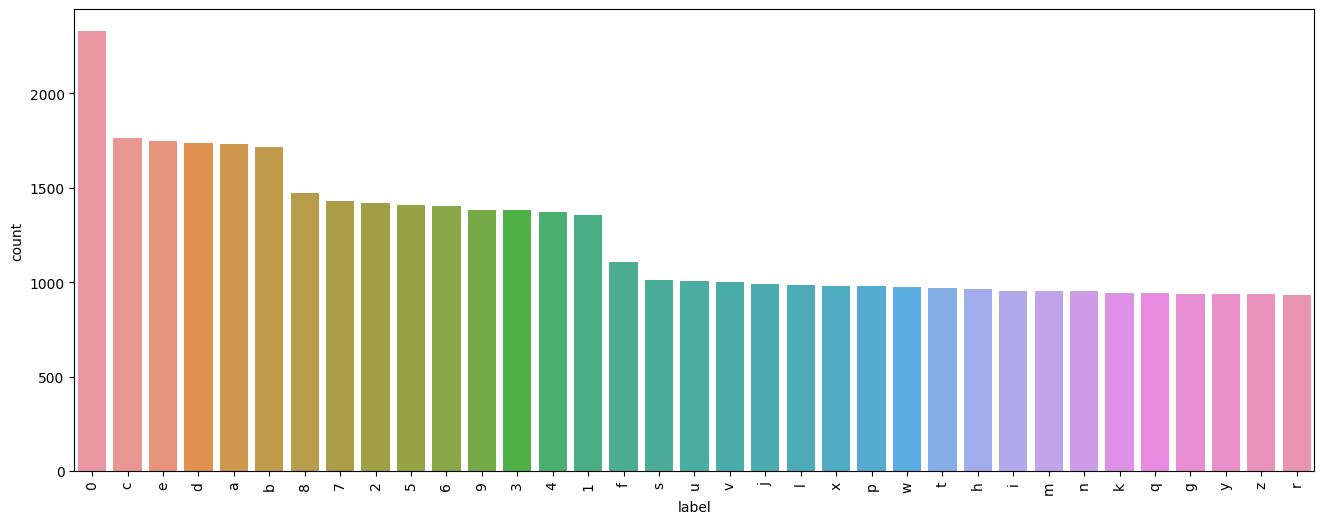

In [ ]:
df = pd.DataFrame([converter[int(i)] for i in torch.cat([train_labels,val_labels]).cpu()], columns = ["label"])
df['count'] = 1
df = df.groupby("label").count().sort_values('count', ascending=False)
plt.figure(figsize=(16., 6.))
sns.barplot(x=df.index, y='count', data=df)
plt.xticks(rotation=90)
plt.show()

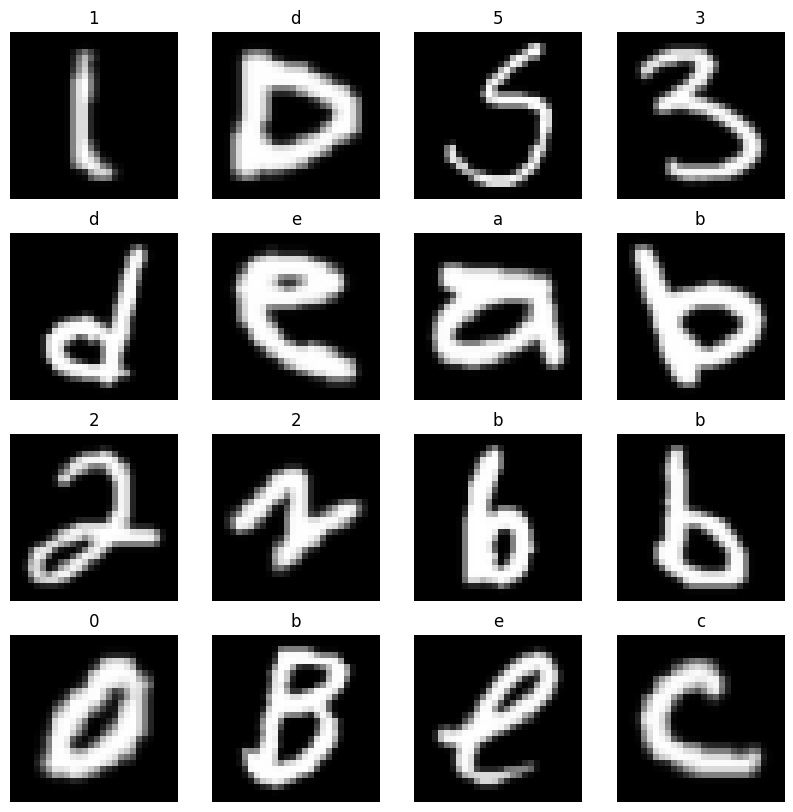

In [ ]:
random_indexes = [random.randint(0, len(val_data)) for i in range(16)]


r, c = 4, 4
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(val_data[random_indexes[i]][0].flip(dims=[1]).rot90(1, [0,1]).cpu(), cmap='gray')
    plt.title(converter[int(val_labels[random_indexes[i]])])
    plt.axis('off')

## augmentations

### perspectiver

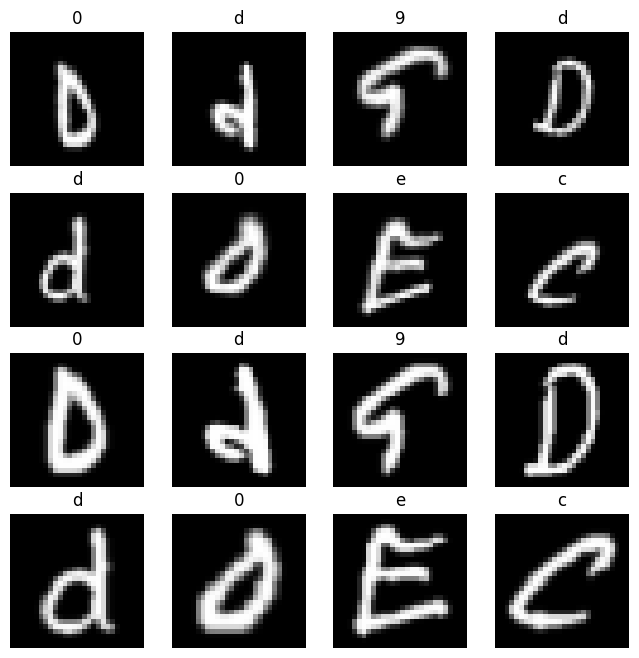

In [ ]:
perspectiver = transforms.RandomPerspective(distortion_scale=0.5, p=1.)
random_indexes = [random.randint(0, len(val_data)) for i in range(16)]


r, c = 4, 4
fig = plt.figure(figsize=(8, 8))
for i in range(8):
    fig.add_subplot(4,4,i+1)
    image = val_data[random_indexes[i]]
    plt.imshow(perspectiver(image)[0].flip(dims=[1]).rot90(1, [0,1]).cpu(), cmap='gray')
    plt.title(converter[int(val_labels[random_indexes[i]])])
    plt.axis('off')

    fig.add_subplot(4,4,i+9)
    plt.imshow(image[0].flip(dims=[1]).rot90(1, [0,1]).cpu(), cmap='gray')
    plt.title(converter[int(val_labels[random_indexes[i]])])
    plt.axis('off')

### rotater

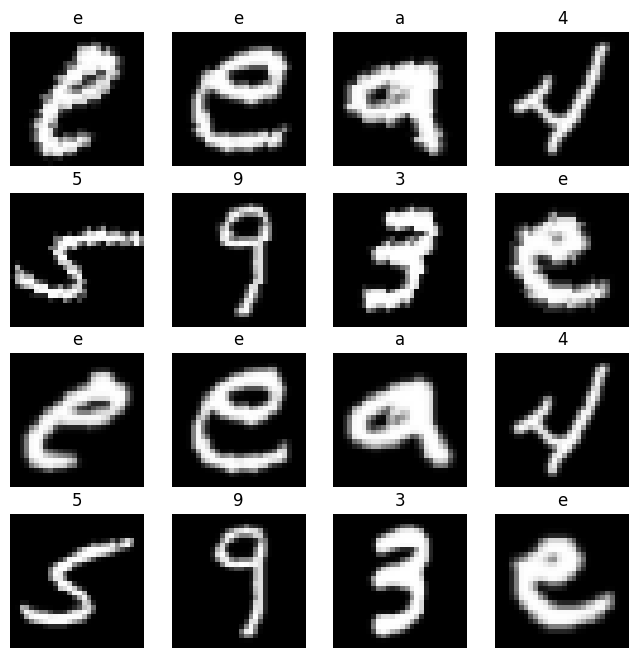

In [ ]:
rotater = transforms.RandomRotation(degrees=(-20,20))
random_indexes = [random.randint(0, len(val_data)) for i in range(16)]


r, c = 4, 4
fig = plt.figure(figsize=(8, 8))
for i in range(8):
    fig.add_subplot(4,4,i+1)
    image = val_data[random_indexes[i]]
    plt.imshow(rotater(image)[0].flip(dims=[1]).rot90(1, [0,1]).cpu(), cmap='gray')
    plt.title(converter[int(val_labels[random_indexes[i]])])
    plt.axis('off')

    fig.add_subplot(4,4,i+9)
    plt.imshow(image[0].flip(dims=[1]).rot90(1, [0,1]).cpu(), cmap='gray')
    plt.title(converter[int(val_labels[random_indexes[i]])])
    plt.axis('off')

### shifter

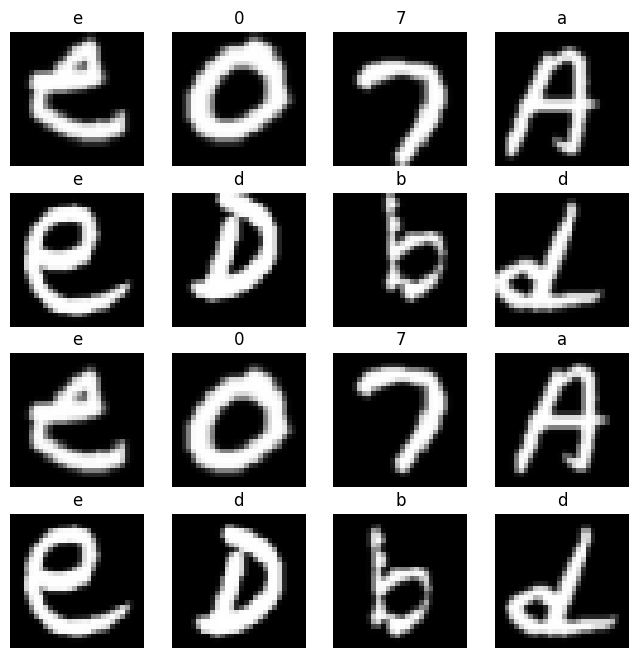

In [ ]:
shifter = transforms.RandomAffine(0, translate = (3/28,3/28))
random_indexes = [random.randint(0, len(val_data)) for i in range(16)]


r, c = 4, 4
fig = plt.figure(figsize=(8, 8))
for i in range(8):
    fig.add_subplot(4,4,i+1)
    image = val_data[random_indexes[i]]
    plt.imshow(shifter(image)[0].flip(dims=[1]).rot90(1, [0,1]).cpu(), cmap='gray')
    plt.title(converter[int(val_labels[random_indexes[i]])])
    plt.axis('off')

    fig.add_subplot(4,4,i+9)
    plt.imshow(image[0].flip(dims=[1]).rot90(1, [0,1]).cpu(), cmap='gray')
    plt.title(converter[int(val_labels[random_indexes[i]])])
    plt.axis('off')

### compressor

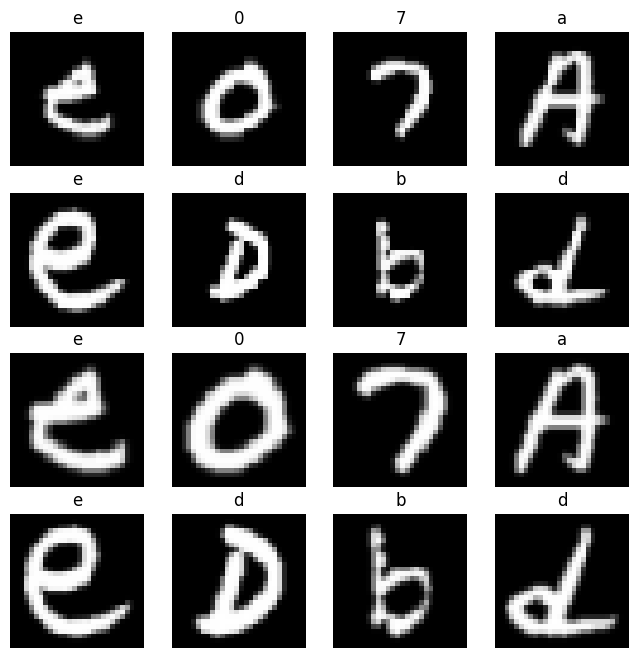

In [ ]:
compressor = torchvision.transforms.RandomAffine(0, scale = (0.7, 0.9))

r, c = 4, 4
fig = plt.figure(figsize=(8, 8))
for i in range(8):
    fig.add_subplot(4,4,i+1)
    image = val_data[random_indexes[i]]
    plt.imshow(compressor(image)[0].flip(dims=[1]).rot90(1, [0,1]).cpu(), cmap='gray')
    plt.title(converter[int(val_labels[random_indexes[i]])])
    plt.axis('off')

    fig.add_subplot(4,4,i+9)
    plt.imshow(image[0].flip(dims=[1]).rot90(1, [0,1]).cpu(), cmap='gray')
    plt.title(converter[int(val_labels[random_indexes[i]])])
    plt.axis('off')

### stratcher

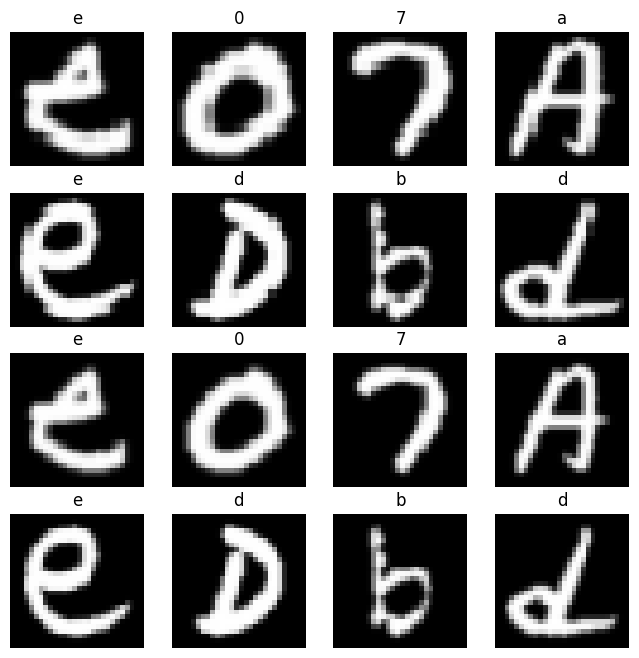

In [ ]:
stratcher = torchvision.transforms.RandomAffine(0, scale = (1.05, 1.1))

r, c = 4, 4
fig = plt.figure(figsize=(8, 8))
for i in range(8):
    fig.add_subplot(4,4,i+1)
    image = val_data[random_indexes[i]]
    plt.imshow(stratcher(image)[0].flip(dims=[1]).rot90(1, [0,1]).cpu(), cmap='gray')
    plt.title(converter[int(val_labels[random_indexes[i]])])
    plt.axis('off')

    fig.add_subplot(4,4,i+9)
    plt.imshow(image[0].flip(dims=[1]).rot90(1, [0,1]).cpu(), cmap='gray')
    plt.title(converter[int(val_labels[random_indexes[i]])])
    plt.axis('off')

## augmeneter

In [ ]:
augmentation = [
    perspectiver,
    rotater,
    shifter,
    compressor,
    stratcher
]
augmentation_combinations = []

for i in range(1,6):
    comb = list(itertools.combinations(augmentation, i))
    for j in comb:
      if not ((compressor in j) and (stratcher in j)):
        augmentation_combinations.append(j)

void = transforms.RandomRotation(degrees=(0,0))
augmentation_combinations.append([void])
augmentation_combinations.append([void])
augmentation_combinations.append([void])
augmentation_combinations.append([void])
augmentation_combinations.append([void])
augmentation_combinations.append([void])
augmentation_combinations.append([void])
augmentation_combinations.append([void])
augmentation_pipelines = transforms.RandomChoice([transforms.Compose(list(combination)) for combination in augmentation_combinations])
augmentation_pipelines

RandomChoice(
    Compose(
    RandomPerspective(p=1.0)
)
    Compose(
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
)
    Compose(
    RandomAffine(degrees=[0.0, 0.0], translate=(0.10714285714285714, 0.10714285714285714))
)
    Compose(
    RandomAffine(degrees=[0.0, 0.0], scale=(0.7, 0.9))
)
    Compose(
    RandomAffine(degrees=[0.0, 0.0], scale=(1.05, 1.1))
)
    Compose(
    RandomPerspective(p=1.0)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
)
    Compose(
    RandomPerspective(p=1.0)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.10714285714285714, 0.10714285714285714))
)
    Compose(
    RandomPerspective(p=1.0)
    RandomAffine(degrees=[0.0, 0.0], scale=(0.7, 0.9))
)
    Compose(
    RandomPerspective(p=1.0)
    RandomAffine(degrees=[0.0, 0.0], scale=(1.05, 1.1))
)
    Compose(
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[0.

## Creating dataset

In [ ]:
val_dataset = TensorDataset(val_data, val_labels)
train_dataset = TensorDataset(train_data, train_labels)
train_dev_sets = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
test_dataset = TensorDataset(test_data, test_labels)

In [ ]:
targets = [int(i) for j,i in train_dev_sets]

count_classes = Counter(targets)
class_weights = {i: 1/c for i, c in count_classes.items()}

dataset_weights = [0]* len(targets)

for i, label in enumerate(bar(targets)):
    dataset_weights[i] = class_weights[label]

N = max(count_classes.values()) * len(count_classes)

sampler = WeightedRandomSampler(dataset_weights, num_samples=N, replacement=True)
train_dataloader = DataLoader(train_dev_sets, batch_size=2156, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=4196, shuffle=True)

  0%|          | 0/43120 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

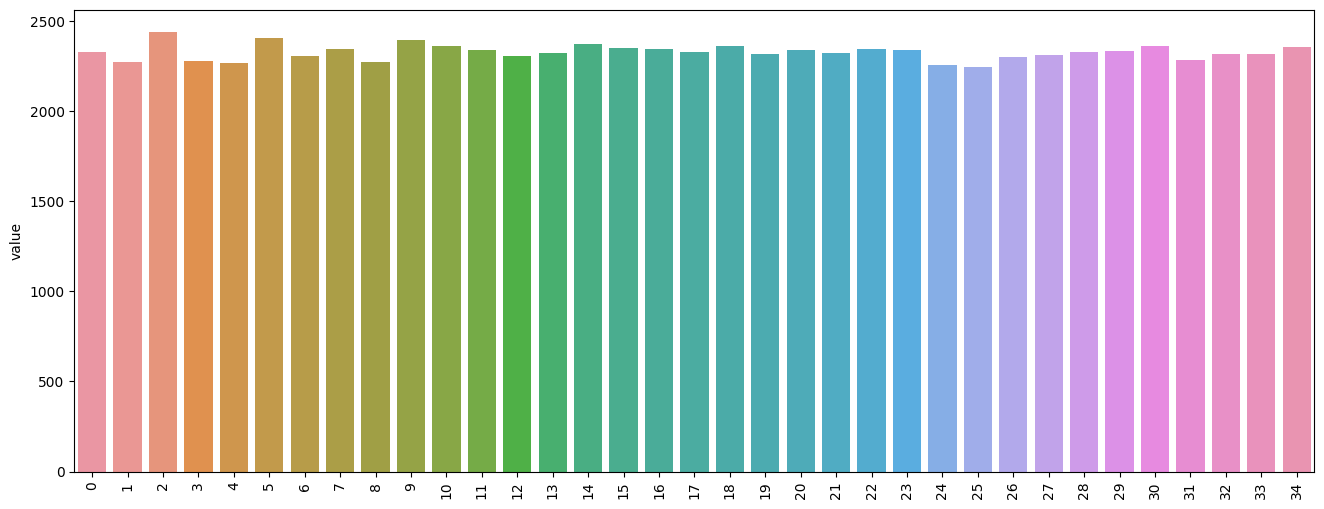

In [ ]:
count=Counter()

for data, labels in bar(train_dataloader):
    count+= Counter(labels.tolist())

df = pd.DataFrame(data=count.values(), index=count.keys(), columns=['value'])
plt.figure(figsize=(16., 6.))
sns.barplot(x=df.index, y='value', data=df)
plt.xticks(rotation=90)
plt.show()

# Epoch fitter

In [ ]:
def fit_epoch(data, labels, optimizer, device, loss_fn, model):
  optimizer.zero_grad()
  data = data.to(device)
  labels = labels.to(device)

  preds = model.forward(data)

  loss_val = loss_fn(preds, labels)
  loss_val.backward()

  optimizer.step()

# Your model (!!!!!!!!!!!!!!!!!)

In [ ]:
########################################
# class with your model

In [ ]:
model = ########################## YourModel.to(device)
summary(model, (1,28,28))

# Test learning (!!!!!!!!!!!!!!!!!!)

In [ ]:
loss = torch.nn.CrossEntropyLoss()
model = ####################### YourModel.to(device)
optimizer = ############################### your optimizer
test_accuracy_history = []
max_epochs = 100 ########################### May be different number


for epoch in bar(range(max_epochs), desc='learning'):
  model.train()
  for data_batch, labels_batch in bar(train_dataloader, leave=False):
    fit_epoch(augmentation_pipelines(data_batch), labels_batch, optimizer, device, loss, model)
  model.eval()
  with torch.no_grad():
    test_acc = 0

    for data_batch_test, labels_batch_test in bar(test_dataloader, desc='testing', leave=False):
      data_batch_test = data_batch_test.to(device)
      labels_batch_test = labels_batch_test.to(device)
      test_preds = model.forward(data_batch_test).data

      accuracy = (test_preds.argmax(dim=1)==labels_batch_test).float().mean().data.cpu()
      test_acc += accuracy / len(test_dataloader)
    test_accuracy_history.append(test_acc)

send_notification()

learning:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

testing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
fig = go.Figure(data=go.Scatter(x=[i for i in range(max_epochs)], y=test_accuracy_history, mode='lines+markers'))

fig.update_layout(title="Accuracy during learning", xaxis_title="epoch", yaxis_title="accuracy")

fig.show()

# Learning model (!!!!!!!!!!!!!!)

In [ ]:
best_accuracy = 0.0
best_state = None
experiments = ############## Minimum 20
max_epochs = ########################## your chosen value

for experiment in bar(range(experiments), desc='Experimenting', leave=False):
    loss = torch.nn.CrossEntropyLoss()
    model = ########################### YourModel.to(device)
    optimizer = ########################################## your optimzier

    for epoch in bar(range(max_epochs), desc='learning', leave = False):
        model.train()
        for data_batch, labels_batch in bar(train_dataloader, leave=False):
            fit_epoch(augmentation_pipelines(data_batch), labels_batch, optimizer, device, loss, model)

        model.eval()

        with torch.no_grad():
            test_acc = 0
            for data_batch_test, labels_batch_test in bar(test_dataloader, desc='testing', leave=False):
                data_batch_test = data_batch_test.to(device)
                labels_batch_test = labels_batch_test.to(device)
                test_preds = model.forward(data_batch_test).data

                accuracy = (test_preds.argmax(dim=1)==labels_batch_test).float().mean().data.cpu()
                test_acc += accuracy / len(test_dataloader)
        if test_acc>best_accuracy:
            best_accuracy = test_acc
            best_state = deepcopy(model.state_dict())
            print("you have new best accuracy: ", best_accuracy)
send_notification(message="Операция завершена. Не забудьте сохранить веса на локальном компьютере")



# Save and test weights (!!!!!!!!!!!!!!!!!!)

In [ ]:
filename = names[number] + "_"+"ModelParameters"+best_accuracy+".pth"

torch.save(best_state, filename)
model = ########################## YourModel.to(device)
model.load_state_dict(torch.load(filename))
model.eval()
with torch.no_grad():
  test_acc = 0
  for data_batch_test, labels_batch_test in bar(test_dataloader, desc='testing', leave=False):
    data_batch_test = data_batch_test.to(device)
    labels_batch_test = labels_batch_test.to(device)
    test_preds = model.forward(data_batch_test).data

    accuracy = (test_preds.argmax(dim=1)==labels_batch_test).float().mean().data.cpu()
    test_acc += accuracy / len(test_dataloader)

print(test_acc)

testing:   0%|          | 0/4 [00:00<?, ?it/s]

tensor(0.8072)
